In [1]:
import dash
from dash import dash_table, dcc, html
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash.dependencies import Input, Output
import plotly.io as pio
import chart_studio.plotly as py
import matplotlib.pyplot as plt
from util.ops_calculator import calculate_total_ops
from util.bops_calculator import calculate_total_bops
from tqdm import tqdm
import numpy as np

In [2]:
import os
import json
import matplotlib.pyplot as plt
from util.ops_calculator import calculate_total_ops
from util.bops_calculator import calculate_total_bops

def load_json_files(directory):
    json_files = []
    if type(directory) is not list:
        for root, _, files in os.walk(directory):
            for file in files:
                if file.endswith("_processed.json"):
                    json_files.append(os.path.join(root, file))
        return json_files
    else:
        for dir in directory:
            for root, _, files in os.walk(dir):
                for file in files:
                    if file.endswith("_processed.json"):
                        json_files.append(os.path.join(root, file))
        return json_files

def process_json_file(file_path):
    with open(file_path, "r") as f:
        try:
            data = json.load(f)
        except json.decoder.JSONDecodeError as e:
            print(e)
            data = None
    # Check if the file is empty
    if not data:
        print(f"Skipping empty file: {file_path}")
        return None
    return data

def extract_reuse_factor(file_path):
    """Extract the reuse factor from the file name."""
    try:
        file_name = os.path.basename(file_path)
        reuse_factor = int(file_name.split("_rf")[1].split("_")[0])
        return reuse_factor
    except (IndexError, ValueError):
        print(f"Error extracting reuse factor from file: {file_path}")
        return None

def save_calculated_data(resource_data, output_file):
    """Save the calculated data to a file."""
    with open(output_file, "w") as f:
        json.dump(resource_data, f)

def load_calculated_data(input_file):
    """Load the calculated data from a file."""
    with open(input_file, "r") as f:
        return json.load(f)

def extract_bitwidth_from_weights(model_config, hls_config):
    """
    Extract the bitwidth from the first non-activation layer's weight parameter.

    Parameters:
        model_config (list): List of layer configurations.
        hls_config (dict): HLS configuration containing precision details.

    Returns:
        int: Bitwidth of the first non-activation layer's weight parameter, or None if not found.
    """
    for i, layer in enumerate(model_config):
        class_name = layer.get("class_name", "")
        #print(class_name)
        if class_name not in ["Activation", "QActivation", "InputLayer"]:
            layer_name = model_config[i+1]["inbound_layers"][0]
            precision = hls_config.get("LayerName", {}).get(layer_name, {}).get("Precision", {}).get("weight", "")
            if "fixed<" in precision:
                try:
                    return int(precision.split("<")[1].split(",")[0])
                except Exception as e:
                    print(f"Error parsing weight precision for layer '{layer_name}': {e}")
                    return None
    print(f"No valid weight precision found in the first non-activation layer. {class_name}")
    return None

def calculate_and_save_data(directory, save_file="calculated_data.json"):
    """Calculate BOPs, OPs, and bitwidth for the dataset and save to a file."""
    json_files = load_json_files(directory)
    print(f"Json files: {len(json_files)}")
    resource_data = {}
    timing_data = {}
    for file_path in tqdm(json_files, desc="Processing files"):
        data = process_json_file(file_path)
        if not data or "model_config" not in data or "resource_report" not in data:
            print(f"Skipping file {file_path} due to missing required keys.")
            continue
        if len(data["resource_report"]) == 0:
            #print(f"Skipping file {file_path} due to missing required keys.")
            continue

        model_config = data["model_config"]
        resource_reports = data["resource_report"]
        timing_reports = data["latency_report"]
        hls_config = data.get("hls_config", {})

        # Extract reuse factor
        reuse_factor = extract_reuse_factor(file_path)
        if reuse_factor is None:
            continue

        # Calculate ops and bops
        try:
            ops = calculate_total_ops(model_config)
        except Exception as e:
            print(f"Error calculating ops for {file_path}: {e}")
            ops = 0

        try:
            bops = calculate_total_bops(model_config, hls_config)
        except Exception as e:
            print(f"Error calculating bops for {file_path}: {e}")
            bops = 0

        # Extract bitwidth
        try:
            bitwidth = extract_bitwidth_from_weights(model_config, hls_config)
        except Exception as e:
            print(f"Error extracting bitwidth for {file_path}: {e}")
            bitwidth = None

        # Collect data for each resource
        for resource, value in resource_reports.items():
            if resource not in resource_data:
                resource_data[resource] = {"ops": [], "bops": [], "values": [], "bitwidth": [], "rf": []}
            resource_data[resource]["ops"].append(ops)
            resource_data[resource]["bops"].append(bops)
            resource_data[resource]["values"].append(float(value))
            resource_data[resource]["bitwidth"].append(bitwidth)
            resource_data[resource]["rf"].append(int(reuse_factor))

        for resource, value in timing_reports.items():
            if resource not in timing_data:
                timing_data[resource] = {"ops": [], "bops": [], "values": [], "bitwidth": [], "rf": []}
            timing_data[resource]["ops"].append(ops)
            timing_data[resource]["bops"].append(bops)
            timing_data[resource]["values"].append(float(value))
            timing_data[resource]["bitwidth"].append(bitwidth)
            timing_data[resource]["rf"].append(int(reuse_factor))


    # Save the calculated data
    save_calculated_data(resource_data, f"resource_{save_file}")
    save_calculated_data(timing_data, f"timing_{save_file}")

In [3]:
#calculate_and_save_data("/mnt/d/hls4ml/wa-hls4ml-search/dataset/fixed_rf/2layer", save_file="calculated_2layer_data.json")

In [4]:
#calculate_and_save_data("/mnt/d/hls4ml/wa-hls4ml-search/dataset/fixed_rf/conv2d", save_file="calculated_conv2d_data.json")

In [5]:

def load_and_generate_plots(save_file="calculated_data.json", prefix=""):
    """Load the saved data and generate scatter plots."""
    resource_data = load_calculated_data(save_file)

    for resource, data in tqdm(resource_data.items(), desc="Generating scatter plots"):
        # Plot for Ops
        plt.figure()
        plt.scatter(data["ops"]/data["rf"], data["values"], label="Ops / Reuse Factor", color="blue", alpha=0.7)
        plt.xscale("symlog")
        plt.yscale("symlog")
        plt.title(f"{prefix} {resource} vs Ops / Reuse Factor (symlog Scale)")
        plt.xlabel("Ops / Reuse Factor (symlog Scale)")
        plt.ylabel(resource)
        plt.legend()
        plt.savefig(f"{prefix}_ops_vs_{resource}_scatter_plot.png")
        plt.show()
        plt.close()

        # Plot for Bops
        plt.figure()
        plt.scatter(data["bops"], data["values"], label="Bops", color="orange", alpha=0.7)
        plt.xscale("symlog")
        plt.yscale("symlog")
        plt.title(f"{prefix} {resource} vs Bops (symlog Scale)")
        plt.xlabel("Bops (Log Scale)")
        plt.ylabel(resource)
        plt.legend()

        plt.savefig(f"{prefix}_bops_vs_{resource}_scatter_plot.png")
        plt.show()
        plt.close()

In [6]:
#load_and_generate_plots(save_file="calculated_2layer_data.json", prefix="2layer")

In [7]:
#load_and_generate_plots(save_file="calculated_conv2d_data.json", prefix="conv2d")

In [8]:
import json
import pandas as pd

def generate_heatmaps_from_file(data_file, output_prefix="heatmap"):
    """
    Generate heatmaps for resource vs bops and resource vs ops/reuse_factor, with color indicating bitwidth.

    Parameters:
        data_file (str): Path to the saved data file.
        output_prefix (str): Prefix for saving the heatmap images.
    """
    resource_data = {}
    try:
        for file in data_file:
            resource_data += json.load(file)
    except:
        with open(data_file, "r") as f:
            resource_data = json.load(f)

    for resource, data in resource_data.items():
        # Convert data to numpy arrays
        ops = np.array(data["ops"])
        bops = np.array(data["bops"])
        values = np.array(data["values"])
        bitwidth = np.array(data["bitwidth"])
        rf = np.array(data["rf"])
        print(resource)
        print(len(values))
        df = pd.DataFrame({"ops": ops, "bops": bops, "values": values, "bitwidth": bitwidth, "rf": rf})
        print(df.dtypes)
        print(df.columns)
        print(df.head())
        print(df.describe())
        #print(f"Max for {resource}: {np.max(values)}")

        # Create heatmaps
        plt.figure(figsize=(10, 8))
        plt.scatter(bops, values, c=rf, cmap="viridis", alpha=0.7)
        plt.colorbar(label="Reuse Factor")
        plt.xscale("log")
        plt.yscale("log")
        plt.title(f"{output_prefix} {resource} vs BOPs (Color: Reuse Factor)")
        plt.xlabel("BOPs (Log Scale)")
        plt.ylabel(resource)
        plt.tight_layout()
        plt.savefig(f"{output_prefix}_bops_vs_{resource}_heatmap.png")
        plt.show()

        plt.figure(figsize=(10, 8))
        plt.scatter(ops/rf, values, c=rf, cmap="viridis", alpha=0.7)
        plt.colorbar(label="Reuse Factor")
        plt.xscale("log")
        plt.yscale("log")
        plt.title(f"{output_prefix} {resource} vs Ops/Reuse Factor (Color: Reuse Factor)")
        plt.xlabel("Ops/Reuse Factor (Log Scale)")
        plt.ylabel(resource)
        plt.tight_layout()
        plt.savefig(f"{output_prefix}_ops_vs_{resource}_heatmap.png")
        plt.show()

In [9]:
#generate_heatmaps_from_file("calculated_2layer_data.json", output_prefix="2layer")

In [10]:
#generate_heatmaps_from_file("calculated_conv2d_data.json", output_prefix="conv2d")

In [11]:
def generate_3d_heatmaps_from_file(data_file, output_prefix="heatmap"):
    import plotly.express as px
    import json
    import pandas as pd
    """
    Generate heatmaps for resource vs bops and resource vs ops/reuse_factor, with color indicating bitwidth.

    Parameters:
        data_file (str): Path to the saved data file.
        output_prefix (str): Prefix for saving the heatmap images.
    """
    with open(data_file, "r") as f:
        resource_data = json.load(f)

    for resource, data in resource_data.items():
        # Convert data to numpy arrays
        ops = np.array(data["ops"])
        bops = np.array(data["bops"])
        values = np.array(data["values"])
        bitwidth = np.array(data["bitwidth"])
        rf = np.array(data["rf"])
        print(resource)
        print(len(values))
        df = pd.DataFrame({"ops": ops, "bops": bops, "values": values, "bitwidth": bitwidth, "rf": rf})
        print(df.dtypes)
        print(df.columns)
        print(df.head())
        print(df.describe())

        fig = px.scatter_3d(df, x='bops', y='rf', z='values',
              color='bitwidth' ,title=f"{output_prefix} {resource} vs Bops (Color: Bitwidth)")
        fig.update_traces(marker_size = 2)
        fig.show()

In [12]:
#generate_3d_heatmaps_from_file("resource_calculated_2layer_data.json", output_prefix="2layer")
#generate_heatmaps_from_file("calculated_conv2d_data.json", output_prefix="conv2d")

In [13]:
#generate_3d_heatmaps_from_file("resource_calculated_conv2d_data.json", output_prefix="conv2d")

In [14]:
#generate_3d_heatmaps_from_file("timing_calculated_2layer_data.json", output_prefix="2layer")

In [15]:
#generate_heatmaps_from_file("calculated_conv2d_data.json", output_prefix="conv2d")
#generate_3d_heatmaps_from_file("timing_calculated_conv2d_data.json", output_prefix="conv2d")

In [16]:
#calculate_and_save_data("/mnt/d/hls4ml/wa-hls4ml-search/dataset/extracted/3layer", save_file="calculated_3layer_data.json")

In [17]:
#calculate_and_save_data("/mnt/d/hls4ml/wa-hls4ml-search/dataset/fixed_rf/conv1d", save_file="calculated_conv1d_data.json")

In [18]:
#generate_3d_heatmaps_from_file("timing_calculated_3layer_data.json", output_prefix="3layer")
#generate_3d_heatmaps_from_file("resource_calculated_3layer_data.json", output_prefix="3layer")

In [19]:
#generate_3d_heatmaps_from_file("timing_calculated_conv1d_data.json", output_prefix="conv1d")
#generate_3d_heatmaps_from_file("resource_calculated_conv1d_data.json", output_prefix="conv1d")

In [20]:
#generate_heatmaps_from_file("timing_calculated_3layer_data.json", output_prefix="3layer")
#generate_heatmaps_from_file("resource_calculated_3layer_data.json", output_prefix="3layer")

In [21]:
#calculate_and_save_data(["/mnt/d/hls4ml/wa-hls4ml-search/dataset/split_dataset/test/Dense", "/mnt/d/hls4ml/wa-hls4ml-search/dataset/split_dataset/val/Dense", "/mnt/d/hls4ml/wa-hls4ml-search/dataset/split_dataset/train/Dense"], save_file="calculated_all_dense_data.json")

In [22]:
#calculate_and_save_data(["/mnt/d/hls4ml/wa-hls4ml-search/dataset/split_dataset/test/Conv", "/mnt/d/hls4ml/wa-hls4ml-search/dataset/split_dataset/val/Conv", "/mnt/d/hls4ml/wa-hls4ml-search/dataset/split_dataset/train/Conv"], save_file="calculated_all_conv_data.json")

In [23]:
#generate_heatmaps_from_file("resource_calculated_all_conv_data.json", output_prefix="all_conv")
#generate_heatmaps_from_file("timing_calculated_all_conv_data.json", output_prefix="all_conv")

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import json

def generate_pretty_heatmaps_from_file(data_file, output_prefix="heatmap"):
    """
    Generate heatmaps for resource vs bops with color indicating reuse factor.
    Skip 'uram' for resource data and 'cycles_min', 'target_clock' for timing data.
    Add heatmap color scale to the figure.

    Parameters:
        data_file (str): Path to the saved data file.
        output_prefix (str): Prefix for saving the heatmap images.
    """
    resource_data = {}
    try:
        for file in data_file:
            resource_data += json.load(file)
    except:
        with open(data_file, "r") as f:
            resource_data = json.load(f)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid
    axes = axes.flatten()
    plot_index = 0

    for resource, data in resource_data.items():
        # Skip unwanted resources
        if resource == "uram" or resource in ["cycles_min", "target_clock"]:
            continue

        if plot_index >= len(axes):
            break  # Limit to 4 plots

        # Convert data to numpy arrays
        bops = np.array(data["bops"])
        values = np.array(data["values"])
        rf = np.array(data["rf"])

        if "resource" in data_file:
            resource_title = resource.upper().replace("_", " ")
        else:
            resource_title = resource.title().replace("_", " ")

        # Scatter plot for BOPs vs resource
        scatter = axes[plot_index].scatter(bops, values, c=rf, cmap="viridis", alpha=0.5)
        axes[plot_index].set_xscale("log")
        axes[plot_index].set_yscale("log")
        axes[plot_index].set_title(f"{resource_title} vs BOPs (Color: Reuse Factor)")
        axes[plot_index].set_xlabel("BOPs")
        axes[plot_index].set_ylabel(resource_title)
        plot_index += 1

    # Adjust horizontal spacing between plots
    fig.subplots_adjust(left=0.1, right=0.85, wspace=0.4, hspace=0.25)  # Increase `wspace` and `hspace` for more space between plots
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Position: [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    cbar.set_label("Reuse Factor")

    if "dense" in data_file:
        if "resource" in data_file:
            fig.suptitle("Resources vs BOPs for MLPs in Dataset", fontsize=16)
        else:
            fig.suptitle("Timing vs BOPs for MLPs in Dataset", fontsize=16)
    else:
        if "resource" in data_file:
            fig.suptitle("Resources vs BOPs for Conv Models in Dataset", fontsize=16)
        else:
            fig.suptitle("Timing vs BOPs for Conv Models in Dataset", fontsize=16)



    # Adjust layout and save the figure
    plt.savefig(f"{output_prefix}_grid_heatmaps.pdf")
    plt.show()

In [25]:
#generate_pretty_heatmaps_from_file("resource_calculated_all_conv_data.json", output_prefix="all_conv_resource")
#generate_pretty_heatmaps_from_file("timing_calculated_all_conv_data.json", output_prefix="all_conv_timing")

In [26]:
#generate_pretty_heatmaps_from_file("resource_calculated_all_dense_data.json", output_prefix="all_dense_resource")
#generate_pretty_heatmaps_from_file("timing_calculated_all_dense_data.json", output_prefix="all_dense_timing")

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import json

def generate_combined_heatmaps_from_files(data_file_resource, data_file_timing, output_prefix="heatmap"):
    """
    Generate heatmaps for resource vs bops and timing vs bops with color indicating reuse factor.
    Skip 'uram' for resource data and 'cycles_min', 'interval_min', 'target_clock' and 'estimated_clock' for timing data.
    Add heatmap color scale to the figure representing reuse factor.

    Parameters:
        data_file_resource (str): Path to the resource data file.
        data_file_timing (str): Path to the timing data file.
        output_prefix (str): Prefix for saving the heatmap images.
    """
    def load_data(file_path):
        with open(file_path, "r") as f:
            return json.load(f)

    resource_data = load_data(data_file_resource)
    timing_data = load_data(data_file_timing)

    fig, axes = plt.subplots(3, 2, figsize=(12, 18))  # 3x2 grid
    axes = axes.flatten()
    plot_index = 0

    for resource, data in resource_data.items():
        # Skip unwanted resources
        if resource == "uram":
            continue

        if plot_index >= len(axes):
            break  # Limit to 6 plots

        # Convert data to numpy arrays
        bops = np.array(data["bops"])
        values = np.array(data["values"])
        rf = np.array(data["rf"])

        resource_title = resource.upper().replace("_", " ")

        # Scatter plot for BOPs vs resource
        scatter = axes[plot_index].scatter(bops, values, c=rf, cmap="viridis", alpha=0.5)
        axes[plot_index].set_xscale("log")
        axes[plot_index].set_yscale("log")
        axes[plot_index].set_title(f"{resource_title} vs BOPs (Color: Reuse Factor)")
        axes[plot_index].set_xlabel("BOPs")
        axes[plot_index].set_ylabel(resource_title)
        plot_index += 1

    for timing, data in timing_data.items():
        # Skip unwanted timing metrics
        if timing in ["cycles_min", "interval_min", "target_clock", "estimated_clock"]:
            continue

        if plot_index >= len(axes):
            break  # Limit to 6 plots

        # Convert data to numpy arrays
        bops = np.array(data["bops"])
        values = np.array(data["values"])
        rf = np.array(data["rf"])

        timing_title = timing.title().replace("_", " ")

        # Scatter plot for BOPs vs timing
        scatter = axes[plot_index].scatter(bops, values, c=rf, cmap="viridis", alpha=0.5)
        axes[plot_index].set_xscale("log")
        axes[plot_index].set_yscale("log")
        axes[plot_index].set_title(f"{timing_title} vs BOPs (Color: Reuse Factor)")
        axes[plot_index].set_xlabel("BOPs")
        axes[plot_index].set_ylabel(timing_title)
        plot_index += 1

    # Adjust spacing between plots
    fig.subplots_adjust(left=0.1, right=0.85, wspace=0.4, hspace=0.3)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Position: [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    cbar.set_label("Reuse Factor")

    if "dense" in output_prefix:
        fig.suptitle("Resources and Timing vs BOPs for Fully-Connected Models in Dataset", fontsize=16)
    else:
        fig.suptitle("Resources and Timing vs BOPs for Convolutional Models in Dataset", fontsize=16)
    # Save the figure
    plt.savefig(f"{output_prefix}_grid_heatmaps.png")
    plt.savefig(f"{output_prefix}_grid_heatmaps.pdf")
    plt.show()

In [28]:
generate_combined_heatmaps_from_files("resource_calculated_all_dense_data.json", "timing_calculated_all_dense_data.json", "all_dense_combined")

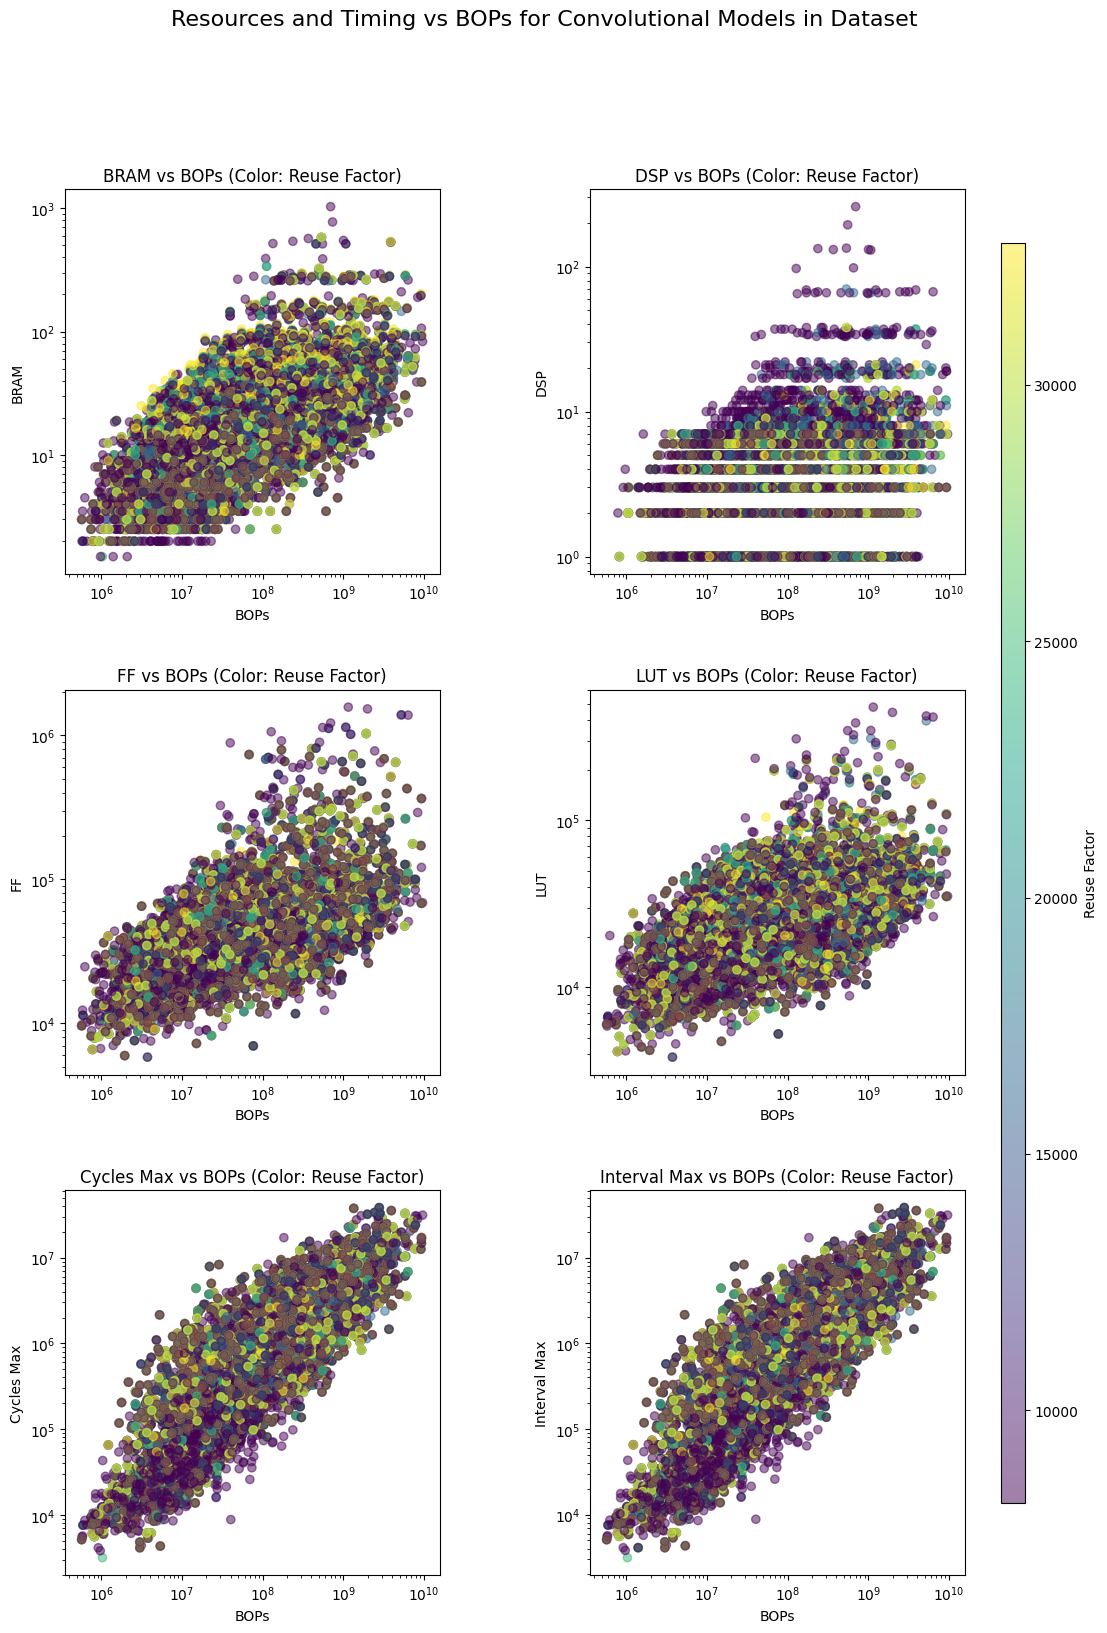

In [29]:
generate_combined_heatmaps_from_files("resource_calculated_all_conv_data.json", "timing_calculated_all_conv_data.json", "all_conv_combined")

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import json

def generate_combined_heatmaps_from_files_precision(data_file_resource, data_file_timing, output_prefix="heatmap"):
    """
    Generate heatmaps for resource vs bops and timing vs bops with color indicating bitwidth.
    Skip 'uram' for resource data and 'cycles_min', 'interval_min', 'target_clock', and 'estimated_clock' for timing data.
    Add heatmap color scale to the figure representing bitwidth.

    Parameters:
        data_file_resource (str): Path to the resource data file.
        data_file_timing (str): Path to the timing data file.
        output_prefix (str): Prefix for saving the heatmap images.
    """
    def load_data(file_path):
        with open(file_path, "r") as f:
            return json.load(f)

    resource_data = load_data(data_file_resource)
    timing_data = load_data(data_file_timing)

    fig, axes = plt.subplots(3, 2, figsize=(12, 18))  # 3x2 grid
    axes = axes.flatten()
    plot_index = 0

    for resource, data in resource_data.items():
        # Skip unwanted resources
        if resource == "uram":
            continue

        if plot_index >= len(axes):
            break  # Limit to 6 plots

        # Convert data to numpy arrays
        bops = np.array(data["bops"])
        values = np.array(data["values"])
        bitwidth = np.array(data["bitwidth"])

        resource_title = resource.upper().replace("_", " ")

        # Scatter plot for BOPs vs resource
        scatter = axes[plot_index].scatter(bops, values, c=bitwidth, cmap="plasma", alpha=0.5)
        axes[plot_index].set_xscale("log")
        axes[plot_index].set_yscale("log")
        axes[plot_index].set_title(f"{resource_title} vs BOPs (Color: Bitwidth)")
        axes[plot_index].set_xlabel("BOPs")
        axes[plot_index].set_ylabel(resource_title)
        plot_index += 1

    for timing, data in timing_data.items():
        # Skip unwanted timing metrics
        if timing in ["cycles_min", "interval_min", "target_clock", "estimated_clock"]:
            continue

        if plot_index >= len(axes):
            break  # Limit to 6 plots

        # Convert data to numpy arrays
        bops = np.array(data["bops"])
        values = np.array(data["values"])
        bitwidth = np.array(data["bitwidth"])

        timing_title = timing.title().replace("_", " ")

        # Scatter plot for BOPs vs timing
        scatter = axes[plot_index].scatter(bops, values, c=bitwidth, cmap="plasma", alpha=0.5)
        axes[plot_index].set_xscale("log")
        axes[plot_index].set_yscale("log")
        axes[plot_index].set_title(f"{timing_title} vs BOPs (Color: Bitwidth)")
        axes[plot_index].set_xlabel("BOPs")
        axes[plot_index].set_ylabel(timing_title)
        plot_index += 1

    # Adjust spacing between plots
    fig.subplots_adjust(left=0.1, right=0.85, wspace=0.4, hspace=0.3)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Position: [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    cbar.set_label("Bitwidth")

    if "dense" in output_prefix:
        fig.suptitle("Resources and Timing vs BOPs for Fully-Connected Models in Dataset", fontsize=16)
    else:
        fig.suptitle("Resources and Timing vs BOPs for Convolutional Models in Dataset", fontsize=16)
    # Save the figure
    plt.savefig(f"{output_prefix}_grid_heatmaps_precision.png")
    plt.show()

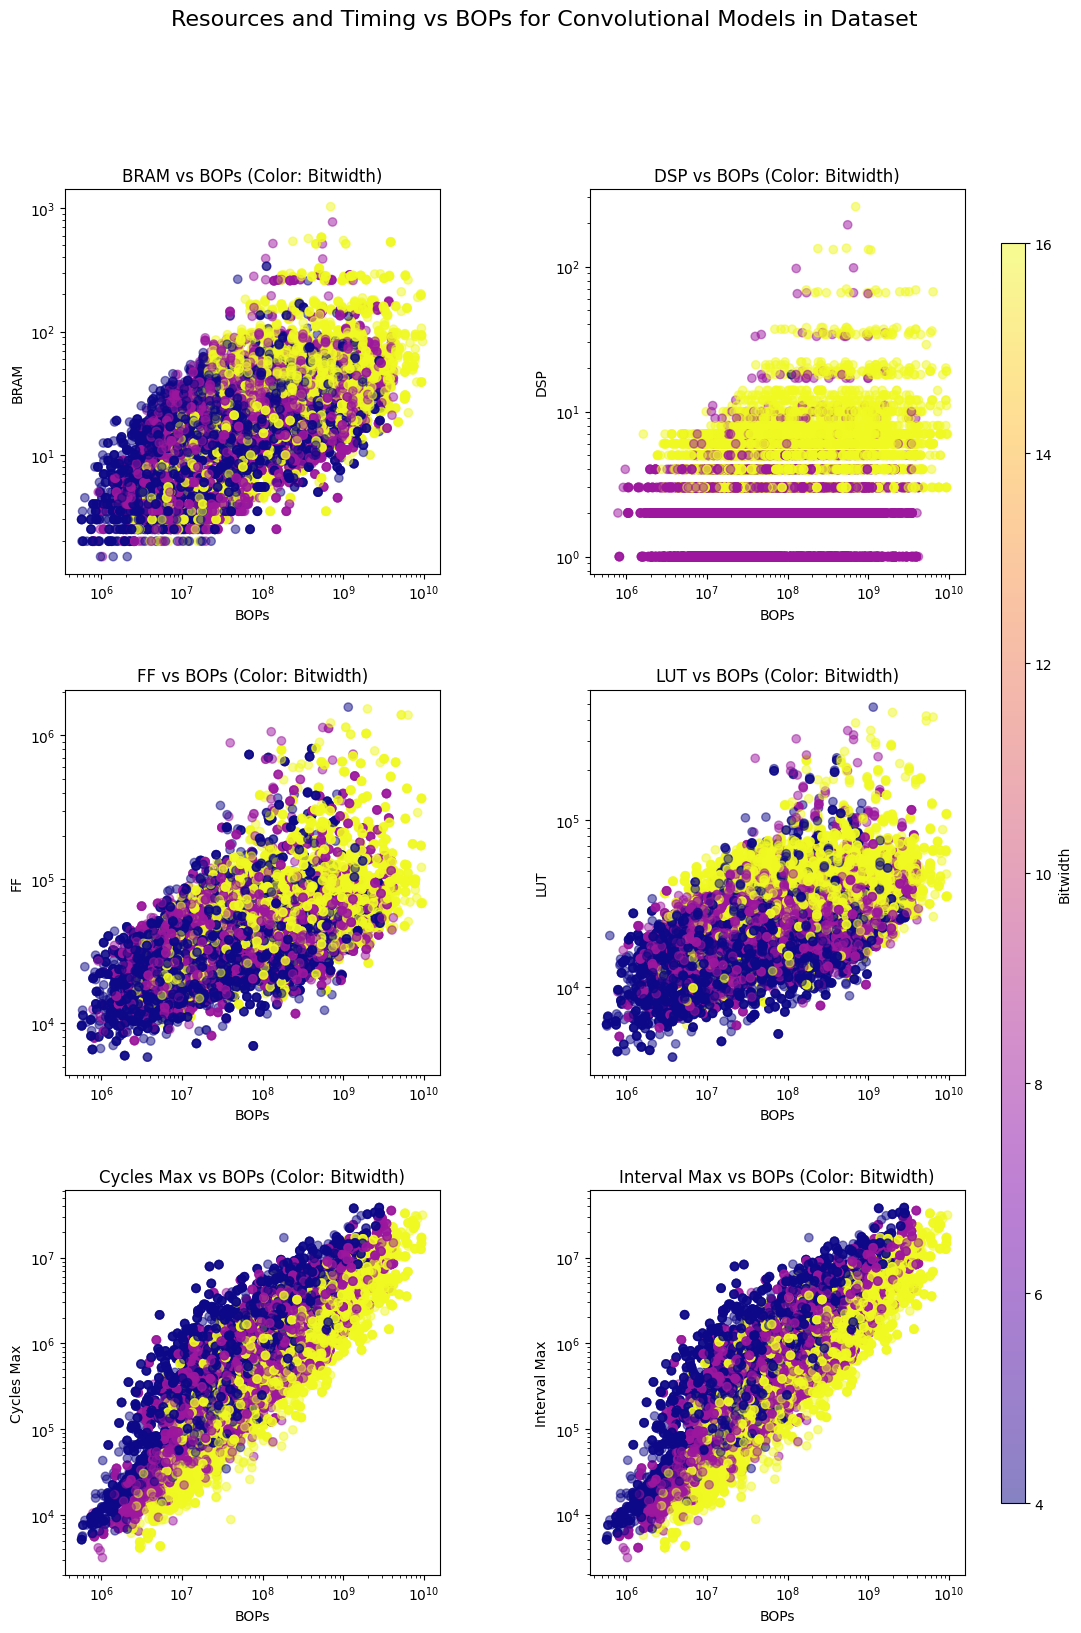

In [31]:
generate_combined_heatmaps_from_files_precision("resource_calculated_all_conv_data.json", "timing_calculated_all_conv_data.json", "all_conv_combined")